
このノートブックを実行するには、次の追加ライブラリが必要です。 Colab での実行は実験的なものであることに注意してください。問題がある場合は、Github の問題を報告してください。


In [1]:
#!pip install d2l==1.0.0-beta0



# Kaggle の画像分類 (CIFAR-10)

 :label: `sec_kaggle_cifar10`

これまで、深層学習フレームワークの高レベル API を使用して、テンソル形式の画像データセットを直接取得してきました。ただし、カスタム画像データセットは画像ファイルの形式で提供されることがよくあります。このセクションでは、生の画像ファイルから始めて、それらを段階的に整理、読み取り、テンソル形式に変換します。

私たちは、コンピュータ ビジョンにおける重要なデータセットである :numref: `sec_image_augmentation`の CIFAR-10 データセットを実験しました。このセクションでは、前のセクションで学んだ知識を適用して、CIFAR-10 画像分類の Kaggle コンペティションを実践します。 (**コンテストの Web アドレスは https://www.kaggle.com/c/cifar-10 です**)

 :numref: `fig_kaggle_cifar10`コンテストの Web ページの情報を示します。結果を送信するには、Kaggle アカウントを登録する必要があります。 

![](../img/kaggle-cifar10.png) :幅: `600px` :ラベル: `fig_kaggle_cifar10`


In [2]:
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn
from d2l import torch as d2l


## データセットの取得と整理

競合データセットはトレーニング セットとテスト セットに分割されており、それぞれ 50,000 枚と 300,000 枚の画像が含まれています。テスト セットでは、10,000 個の画像が評価に使用されますが、残りの 290,000 個の画像は評価されません。これらは、テスト セットの*手動で*ラベル付けされた結果を不正使用するのを困難にするためだけに含まれています。このデータセット内の画像はすべて PNG カラー (RGB チャネル) 画像ファイルであり、高さと幅は両方とも 32 ピクセルです。画像は飛行機、車、鳥、猫、鹿、犬、カエル、馬、船、トラックの計10カテゴリーを網羅しています。 :numref: `fig_kaggle_cifar10`の左上隅には、データセット内の飛行機、車、鳥の画像がいくつか表示されています。

### データセットのダウンロード

Kaggle にログインした後、:numref: `fig_kaggle_cifar10`に示されている CIFAR-10 画像分類コンテスト Web ページの [データ] タブをクリックし、[すべてダウンロード] ボタンをクリックしてデータセットをダウンロードできます。ダウンロードしたファイルを`../data`に解凍し、その中にある`train.7z`と`test.7z`を解凍すると、次のパスにデータセット全体が見つかります。
-  `../data/cifar-10/train/[1-50000].png`
-  `../data/cifar-10/test/[1-300000].png`
-  `../data/cifar-10/trainLabels.csv`
-  `../data/cifar-10/sampleSubmission.csv`

ここで、 `train`ディレクトリと`test`ディレクトリにはそれぞれトレーニング イメージとテスト イメージが含まれ、 `trainLabels.csv`トレーニング イメージのラベルを提供し、 `sample_submission.csv`はサンプル送信ファイルです。

簡単に開始できるように、**最初の 1000 枚のトレーニング画像と 5 枚のランダムなテスト画像を含むデータセットの小規模サンプルを提供します。** ] Kaggle コンテストの完全なデータセットを使用するには、次の`demo`変数を`False`に設定する必要があります。


In [3]:
#@save
d2l.DATA_HUB['cifar10_tiny'] = (d2l.DATA_URL + 'kaggle_cifar10_tiny.zip',
                                '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')

# If you use the full dataset downloaded for the Kaggle competition, set
# `demo` to False
demo = True

if demo:
    data_dir = d2l.download_extract('cifar10_tiny')
else:
    data_dir = '../data/cifar-10/'


### [**データセットの整理**]

モデルのトレーニングとテストを容易にするためにデータセットを整理する必要があります。まず、csv ファイルからラベルを読み取りましょう。次の関数は、ファイル名の非拡張子部分をそのラベルにマップする辞書を返します。


In [4]:
#@save
def read_csv_labels(fname):
    """Read `fname` to return a filename to label dictionary."""
    with open(fname, 'r') as f:
        # Skip the file header line (column name)
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))

labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
print('# training examples:', len(labels))
print('# classes:', len(set(labels.values())))

# training examples: 1000
# classes: 10



次に、 `reorg_train_valid`関数を定義して [**元のトレーニング セットから検証セットを分割します。** ] この関数の引数`valid_ratio` 、元のトレーニング セットの例の数に対する検証セットの例の数の比率です。具体的には、最も例の少ないクラスの画像数を$n$、比率を$r$とします。検証セットは、クラスごとに $\max(\lfloor nr\rfloor,1)$ イメージを分割します。例として`valid_ratio=0.1`を使用してみましょう。元のトレーニング セットには 50,000 個の画像があるため、パス`train_valid_test/train`でトレーニングに使用される 45,000 個の画像があり、他の 5,000 個の画像はパス`train_valid_test/valid`で検証セットとして分割されます。データセットを整理すると、同じクラスの画像が同じフォルダーに配置されます。


In [5]:
#@save
def copyfile(filename, target_dir):
    """Copy a file into a target directory."""
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)

#@save
def reorg_train_valid(data_dir, labels, valid_ratio):
    """Split the validation set out of the original training set."""
    # The number of examples of the class that has the fewest examples in the
    # training dataset
    n = collections.Counter(labels.values()).most_common()[-1][1]
    # The number of examples per class for the validation set
    n_valid_per_label = max(1, math.floor(n * valid_ratio))
    label_count = {}
    for train_file in os.listdir(os.path.join(data_dir, 'train')):
        label = labels[train_file.split('.')[0]]
        fname = os.path.join(data_dir, 'train', train_file)
        copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                     'train_valid', label))
        if label not in label_count or label_count[label] < n_valid_per_label:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'valid', label))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'train', label))
    return n_valid_per_label


以下の`reorg_test`関数は**、予測中にデータをロードするためのテスト セットを編成します。** 】


In [6]:
#@save
def reorg_test(data_dir):
    """Organize the testing set for data loading during prediction."""
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        copyfile(os.path.join(data_dir, 'test', test_file),
                 os.path.join(data_dir, 'train_valid_test', 'test',
                              'unknown'))


最後に、関数を使用して`read_csv_labels` 、 `reorg_train_valid` 、および`reorg_test` (上で定義した関数) を [**呼び出し**] ます**。**


In [7]:
def reorg_cifar10_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    reorg_train_valid(data_dir, labels, valid_ratio)
    reorg_test(data_dir)


ここでは、データセットの小規模サンプルに対してのみバッチ サイズを 32 に設定します。 Kaggle コンペティションの完全なデータセットをトレーニングおよびテストする場合、 `batch_size` 128 などの大きな整数に設定する必要があります。トレーニング サンプルの 10% をハイパーパラメータ調整用の検証セットとして分割しました。


In [8]:
batch_size = 32 if demo else 128
valid_ratio = 0.1
reorg_cifar10_data(data_dir, valid_ratio)


## [**画像拡張**]

画像拡張を使用して過剰適合に対処します。たとえば、トレーニング中に画像をランダムに水平方向に反転できます。カラー画像の RGB 3 チャネルの標準化も実行できます。以下に、調整できる操作の一部を示します。


In [9]:
transform_train = torchvision.transforms.Compose([
    # Scale the image up to a square of 40 pixels in both height and width
    torchvision.transforms.Resize(40),
    # Randomly crop a square image of 40 pixels in both height and width to
    # produce a small square of 0.64 to 1 times the area of the original
    # image, and then scale it to a square of 32 pixels in both height and
    # width
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0),
                                                   ratio=(1.0, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    # Standardize each channel of the image
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])


テスト中は、評価結果のランダム性を取り除くために画像の標準化のみを実行します。


In [10]:
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])


## データセットの読み取り

次に、[**生の画像ファイルで構成される整理されたデータセットを読み取ります**]。各例には画像とラベルが含まれています。


In [11]:
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]


トレーニング中に、[**上で定義したすべての画像拡張操作を指定する**]必要があります。ハイパーパラメータ調整中のモデル評価に検証セットが使用される場合、画像拡張によるランダム性が導入されるべきではありません。最終予測の前に、すべてのラベル付きデータを最大限に活用するために、トレーニング セットと検証セットを組み合わせてモデルをトレーニングします。


In [12]:
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)


## [**モデル**] の定義



:numref: `sec_resnet`で説明されている ResNet-18 モデルを定義します。


In [13]:
def get_net():
    num_classes = 10
    net = d2l.resnet18(num_classes, 3)
    return net

loss = nn.CrossEntropyLoss(reduction="none")


## 「**トレーニング機能**」の定義

モデルを選択し、検証セットでのモデルのパフォーマンスに応じてハイパーパラメーターを調整します。以下では、モデルトレーニング関数`train`を定義します。


In [14]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
                              weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, features, labels,
                                          loss, trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')


## [**モデルのトレーニングと検証**]

これで、モデルをトレーニングして検証できるようになりました。次のすべてのハイパーパラメータを調整できます。たとえば、エポック数を増やすことができます。 `lr_period`と`lr_decay`それぞれ 4 と 0.9 に設定されている場合、最適化アルゴリズムの学習率は 4 エポックごとに 0.9 倍になります。デモを簡単にするために、ここでは 20 エポックのみをトレーニングします。


train loss 0.595, train acc 0.790, valid acc 0.453
1419.0 examples/sec on [device(type='cuda', index=0)]


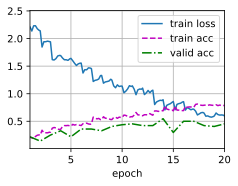

In [15]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 2e-4, 5e-4
lr_period, lr_decay, net = 4, 0.9, get_net()
net(next(iter(train_iter))[0])
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)


## [**テストセットの分類**] と Kaggle への結果の送信

ハイパーパラメーターを含む有望なモデルを取得した後、すべてのラベル付きデータ (検証セットを含む) を使用してモデルを再トレーニングし、テスト セットを分類します。


train loss 0.522, train acc 0.824
1430.0 examples/sec on [device(type='cuda', index=0)]


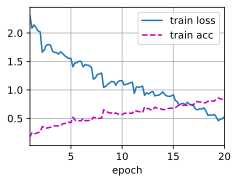

In [16]:
net, preds = get_net(), []
net(next(iter(train_valid_iter))[0])
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

for X, _ in test_iter:
    y_hat = net(X.to(devices[0]))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key=lambda x: str(x))
df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x])
df.to_csv('submission.csv', index=False)


上記のコードは、Kaggle コンテストの要件を満たす形式の`submission.csv`ファイルを生成します。結果を Kaggle に送信する方法は、 :numref: `sec_kaggle_house`の方法と似ています。

## まとめ
- 生の画像ファイルを含むデータセットを、必要な形式に整理した後、読み取ることができます。


- 画像分類コンテストでは、畳み込みニューラル ネットワークと画像拡張を使用できます。



## 演習
1. この Kaggle コンテストでは完全な CIFAR-10 データセットを使用してください。ハイパーパラメータを、 `batch_size = 128` 、 `num_epochs = 100` 、 `lr = 0.1` 、 `lr_period = 50` 、および`lr_decay = 0.1`として設定します。このコンテストでどのような精度とランキングを達成できるかを確認してください。さらに改善してもらえますか？
1. 画像拡張を使用しない場合、どの程度の精度が得られますか?



[ディスカッション](https://discuss.d2l.ai/t/1479)
